<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

### Tâche 2 : Analyse de sentiments, représentations des textes

In [2]:
from os import listdir
from os.path import isfile, join
import re
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#from wordcloud import WordCloud
import time
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import sklearn.naive_bayes as bayes
from sklearn import svm, linear_model as lin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

Lecture de l'ensemble de revues étiquetées (positifs et négatifs).

In [3]:
posfiles = [f for f in listdir("./movies1000/pos") if isfile(join("./movies1000/pos", f))]
negfiles = [f for f in listdir("./movies1000/neg") if isfile(join("./movies1000/neg", f))]

pos = [open("./movies1000/pos/"+f).read() for f in posfiles]
lab_pos = [1 for _ in range(len(pos))]
neg = [open("./movies1000/neg/"+f).read() for f in negfiles]
lab_neg = [-1 for _ in range(len(neg))]

In [4]:
print("Nombre de revues (positives)",str(len(lab_pos)))
print("Nombre de revues (negatives)",str(len(lab_neg)))

Nombre de revues (positives) 1000
Nombre de revues (negatives) 1000


In [5]:
print(pos[2])

you've got mail works alot better than it deserves to . 
in order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . 
no real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . 
essentially , it goes against and defies all concepts of good contemporary filmmaking . 
it's overly sentimental and at times terribly mushy , not to mention very manipulative . 
but oh , how enjoyable that manipulation is . 
but there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . 
it couldn't have been the directing , because both films were helmed by the same woman . 
i haven't quite yet figured out what i like

La fonction de preprocessing qui permet de nettoyer et d'épurer une chaîne de caractères

In [6]:
def preprocess(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub(' \d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)

    return s

In [7]:
def stemmatisation(s):
    stemmer = SnowballStemmer('english',ignore_stopwords=True)
    words = s.split()
    words_stem = [stemmer.stem(w) for w in words]
    return " ".join(words_stem)

In [8]:
def lemmatisation(s):
    lemmatizer = WordNetLemmatizer()
    words = s.split()
    words_lema = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words_lema)

In [9]:
preprocess(pos[2])

"you've got mail works alot better than it deserves to in order to make the film a success all they had to do was cast two extremely popular and attractive stars have them share the screen for about two hours and then collect the profits no real acting was involved and there is not an original or inventive bone in it's body it's basically a complete re shoot of the shop around the corner only adding a few modern twists essentially it goes against and defies all concepts of good contemporary filmmaking it's overly sentimental and at times terribly mushy not to mention very manipulative but oh how enjoyable that manipulation is but there must be something other than the casting and manipulation that makes the movie work as well as it does because i absolutely hated the previous ryan hanks teaming sleepless in seattle it couldn't have been the directing because both films were helmed by the same woman i haven't quite yet figured out what i liked so much about you've got mail but then agai

In [10]:
stemmatisation(preprocess(pos[2]))

"you've got mail work alot better than it deserv to in order to make the film a success all they had to do was cast two extrem popular and attract star have them share the screen for about two hour and then collect the profit no real act was involv and there is not an origin or invent bone in it's bodi it's basic a complet re shoot of the shop around the corner only ad a few modern twist essenti it goe against and defi all concept of good contemporari filmmak it's over sentiment and at time terribl mushi not to mention very manipul but oh how enjoy that manipul is but there must be someth other than the cast and manipul that make the movi work as well as it does because i absolut hate the previous ryan hank team sleepless in seattl it couldn't have been the direct because both film were helm by the same woman i haven't quit yet figur out what i like so much about you've got mail but then again is that realli import if you like someth so much why even question it again the storylin is a

In [11]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
" ".join([w for w in stemmatisation(preprocess(pos[2])).split() if w not in stopwords.words('english')])

'got mail work alot better deserv order make film success cast two extrem popular attract star share screen two hour collect profit real act involv origin invent bone bodi basic complet shoot shop around corner ad modern twist essenti goe defi concept good contemporari filmmak sentiment time terribl mushi mention manipul oh enjoy manipul must someth cast manipul make movi work well absolut hate previous ryan hank team sleepless seattl direct film helm woman quit yet figur like much got mail realli import like someth much even question storylin clich come tom hank play joe fox insan likeabl owner discount book chain meg ryan play kathleen kelley even insan likeabl proprietor famili run children book shop call nice homag shop around corner fox kelley soon becom bitter rival new fox book store open right across block small busi littl know alreadi love internet neither parti know person true ident rest stori import serv mere backdrop two star share screen sure mild interest subplot fail co

In [13]:
corpus_train = [stemmatisation(preprocess(d)) for d in pos + neg]

In [14]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(corpus_train)

In [15]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("10 mots du vocabulaire : ", vocab[5000:5010])

Nombre de mots dans le vocabulaire :  24956
10 mots du vocabulaire :  ['cyndi' 'cynic' 'cynthia' 'cypher' 'cyr' 'cyril' 'cyrus' 'cystic' 'czech'
 'czechoslovakia']


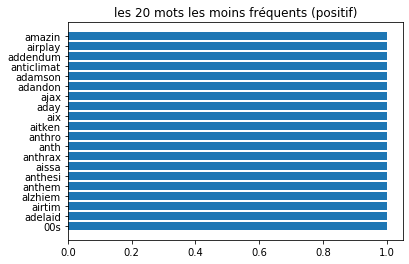

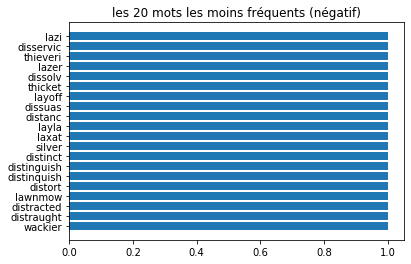

In [16]:
tf_pos = X.toarray().sum(0)[:1000]
tf_neg = X.toarray().sum(0)[1000:]

n = 20

ind_p = tf_pos.argsort()[:n]
ind_n = tf_neg.argsort()[:n]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les moins fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les moins fréquents (négatif)")
plt.show()

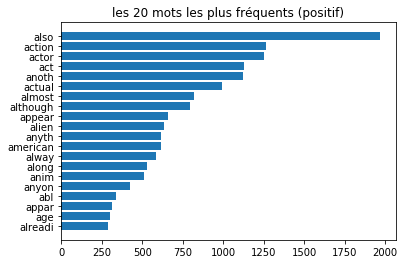

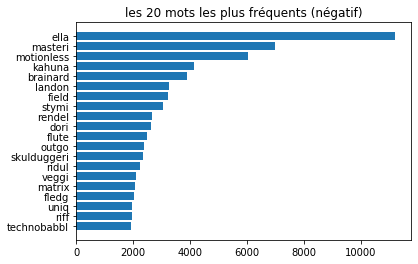

In [29]:
ind_p = tf_pos.argsort()[-n:]
ind_n = tf_neg.argsort()[-n:]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les plus fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les plus fréquents (négatif)")
plt.show()

In [35]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test,y_test))
        
    return sum(scores)/n_splits

In [19]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

In [20]:
def get_len_vocab(corpus, ngram, stop_words = None):
    vectorizer = CountVectorizer(stop_words = stop_words, ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

# Campagne d'évaluation et comparaison de 3 modèles de classification

In [43]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur):
    if classifieur == "bayes":
        clf = bayes.MultinomialNB()
    elif classifieur == "svm":
        clf = svm.LinearSVC(C = 0.1, max_iter = 50000, dual=False)
    elif classifieur == "reg_log":
        clf = lin.LogisticRegression(C = 0.1, max_iter = 10000)
    else:
        raise ValueError("No classifier between, svm, bayes and lin")
    
    tic = time.perf_counter() 
        
    ordinate = [[] for i in range(4)]
    abscissa = np.linspace(20, get_len_vocab(corpus, ngram), 20, dtype = int)
    abscissa_sw = np.linspace(20, get_len_vocab(corpus, ngram, stop_words), 20, dtype = int)
    
    # Sans stop words
    for step in abscissa:
        vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram))
        tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram))
        X_v = vectorizer.fit_transform(corpus)
        X_t = tf_idf.fit_transform(corpus)
        ordinate[0].append(cross_validation(clf, X_v, labels))
        ordinate[1].append(cross_validation(clf, X_t, labels))
             
    # Avec stop words
    for step in abscissa_sw:
        vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), stop_words=stop_words)
        tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram), stop_words=stop_words)
        X_v = vectorizer.fit_transform(corpus)
        X_t = tf_idf.fit_transform(corpus)
        ordinate[2].append(cross_validation(clf, X_v, labels))
        ordinate[3].append(cross_validation(clf, X_t, labels))

    plt.show()
    plt.plot(abscissa, ordinate[0],label='TF')
    plt.plot(abscissa, ordinate[1],label='TFIDF')
    plt.plot(abscissa_sw, ordinate[2],label='stopword TF')
    plt.plot(abscissa_sw, ordinate[3],label='stopword TFIDF')
    plt.legend()
    plt.title("Accuracy en fonction du nb de mots conservés : "+mot_gram(ngram)+", "+classifieur)
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("Accuracy")
    plt.show()
    
    ind = np.argmax(ordinate, axis = 1)
    max_gram = [abscissa[ind[0]], abscissa[ind[1]], abscissa_sw[ind[2]], abscissa_sw[ind[3]]] 

    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    print("Meilleur score <"+str(ordinate[0][ind[0]])+"> pour TF avec "+(str(max_gram[0]))+" "+mot_gram(ngram))
    print("Meilleur score <"+str(ordinate[1][ind[1]])+"> pour TF-IDF avec "+(str(max_gram[1]))+" "+mot_gram(ngram))
    print("Meilleur score <"+str(ordinate[2][ind[2]])+"> pour TF sans stopwords avec "+(str(max_gram[2]))+" "+mot_gram(ngram))
    print("Meilleur score <"+str(ordinate[3][ind[3]])+"> pour TF-IDF sans stopwords avec "+(str(max_gram[3]))+" "+mot_gram(ngram))
    
    return max_gram

### 1- SVM

UNIGRAM

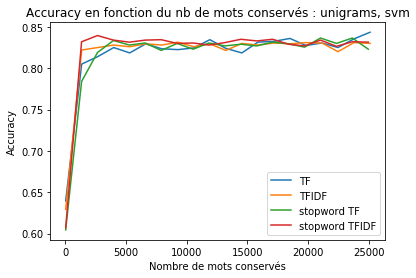

Temps d'éxécution : 325.15 secondes
Meilleur score <0.8435> pour TF avec 25099 unigrams
Meilleur score <0.8314999999999999> pour TF-IDF avec 9259 unigrams
Meilleur score <0.8365> pour TF sans stopwords avec 23643 unigrams
Meilleur score <0.8394999999999999> pour TF-IDF sans stopwords avec 2644 unigrams


In [44]:
svm1 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 1, "svm")

BIGRAM

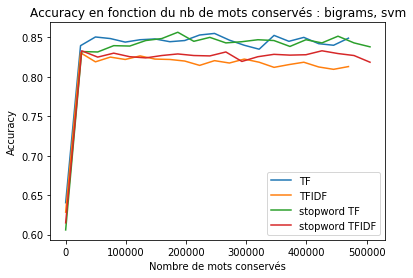

Temps d'éxécution : 2476.08 secondes
Meilleur score <0.8550000000000001> pour TF avec 247373 bigrams
Meilleur score <0.8305> pour TF-IDF avec 24755 bigrams
Meilleur score <0.8564999999999999> pour TF sans stopwords avec 186367 bigrams
Meilleur score <0.833> pour TF-IDF sans stopwords avec 26641 bigrams


In [45]:
svm2 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 2, "svm")

TRIGRAM

In [ ]:
svm3 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 3, "svm")

### 2- Régression Logistique

UNIGRAM

In [ ]:
logistic1 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 1, "reg_log")

BIGRAM

In [ ]:
logistic2 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 2, "reg_log")

TRIGRAM

In [ ]:
logistic3 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 2, "reg_log")

### 3-Naive Bayes

UNIGRAM

In [ ]:
bayes1 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 1, "bayes")

BIGRAM

In [ ]:
bayes2 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 2, "bayes")

TRIGRAM

In [ ]:
bayes3 = campagne_evaluation(corpus_train, np.array(lab_pos+lab_neg), stopwords.words('english'), 3, "bayes")

## Génération des prédictions pour le dataset de test

# Conclusion